# Constellation and Chain Analysis: Transmitters and Receivers Example

<img src="TransmitterAndReceiver.jpg" alt="Drawing" style="width: 800px;"/>

**Terminology**
* Node = Object in STK
* Edge = Access between two objects in STK
* Strand = The sequence of nodes and edges to complete access in a chain

**This notebook shows how to:**
* Find the least latency path between a starting constellation and ending constellation through a network of receivers and transmitters. The connecting constellations in the scenario can have logical constraints so they can only transmit to receivers on other satellites
* Typical STK constraints such as range, link duration, Eb/No, etc can be taken into account
*  Compute summary statistics for time delay and number of hops
* Load the shortest path data back into STK



In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 70)
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
import seaborn as sns
import matplotlib.pyplot as plt
from chainPathLib import *
import time
import networkx as nx

## Constellation Names, Computation Time, and Processing Delays

In [2]:
# Inputs for Chain Analysis
startingConstellation = 'Targets' # Will be used as the start of the chain
firstConnectingConstellation = 'SatRec' # Will be used to connect the the starting and ending constellation  
secondConnectingConstellation = 'SatTrans' # Will be used to connect the the starting and ending constellation  
endingConstellation = 'GroundStations' # Will be used as the end of the chain

start = 0 # EpSec
stop = 3600*1 # EpSec
metric = 'timeDelay' # 'distance','timeDelay' # could optionally add: min hops+secondary metric, fewest hand off etc
nodeDelays = {'SatRec':0.005,'SatTrans':0.005} # Add in time delays. Provide the constellation name in STK and the node delays
stkVersion = 12

In [3]:
# Connect to STK
stkApp = GetActiveObject('STK{}.Application'.format(stkVersion))
stkRoot = stkApp.Personality2
stkRoot.UnitPreferences.SetCurrentUnit('DateFormat','EpSec')
stkRoot.ExecuteCommand('Units_SetConnect / Date "EpochSeconds"');
stkRoot.ExecuteCommand('VO * ObjectLine DeleteAll');

In [4]:
# # Example of how to adjust all transmitters power
# transmitterPaths = FilterObjectsByType(stkRoot,'Transmitter')
# for transmitterPath in transmitterPaths:
#     transmitter = stkRoot.GetObjectFromPath(transmitterPath)
#     transmitter2 = transmitter.QueryInterface(STKObjects.IAgTransmitter)
#     transmitterModel = transmitter2.Model.QueryInterface(STKObjects.IAgTransmitterModelSimple)
#     transmitterModel.Eirp = 16.9

In [5]:
# Build chains and add node processing delays
if not secondConnectingConstellation:
    chainNames = createChains(stkRoot,startingConstellation,firstConnectingConstellation,endingConstellation)
else:
    chainNames = createChains(stkRoot,startingConstellation,firstConnectingConstellation,endingConstellation,secondConnectingConstellation=secondConnectingConstellation)
nodeDelaysByNode = getNodeDelaysByNode(stkRoot,nodeDelays,chainNames=chainNames)

## Compute  Strands and Distances

In [6]:
# Compute strands
t1 = time.time()
strands,dfStrands = getAllStrands(stkRoot,chainNames,start,stop)
print(time.time()-t1)
dfStrands

25.53555703163147


,strand,start,stop,dur,num hops
380,"(Satellite/LEO13/Transmitter/Transmitter5, Facility/Facility5/Rece...",0.000000,26.203969,26.203969,0.0
121,"(Satellite/LEO21/Transmitter/Transmitter9, Satellite/LEO54/Receive...",0.000000,39.749043,39.749043,0.0
145,"(Satellite/LEO24/Transmitter/Transmitter14, Satellite/LEO51/Receiv...",0.000000,39.749043,39.749043,0.0
271,"(Satellite/LEO51/Transmitter/Transmitter29, Satellite/LEO24/Receiv...",0.000000,39.759454,39.759454,0.0
297,"(Satellite/LEO54/Transmitter/Transmitter32, Satellite/LEO21/Receiv...",0.000000,39.759454,39.759454,0.0
...,...,...,...,...,...
406,"(Satellite/LEO65/Transmitter/Transmitter39, Facility/Facility5/Rec...",3508.477478,3557.914630,49.437153,0.0
85,"(Satellite/LEO13/Transmitter/Transmitter5, Satellite/LEO45/Receive...",3582.124408,3600.000000,17.875592,0.0
111,"(Satellite/LEO16/Transmitter/Transmitter8, Satellite/LEO42/Receive...",3582.124408,3600.000000,17.875592,0.0
228,"(Satellite/LEO42/Transmitter/Transmitter24, Satellite/LEO16/Receiv...",3582.134817,3600.000000,17.865183,0.0


In [7]:
# Compute node positions, distances and time delays

# Time resolution of distance calculation
step = 10 # sec

t1 = time.time()
nodesTimesPos = computeNodesPosOverTime(stkRoot,strands,start,stop,step) # Pull node position over time
t2 = time.time()
print(t2-t1)

t1 = time.time()
strandsAtTimes = getStrandsAtTimes(strands,start,stop,step) # Discretize strand intervals into times
t2 = time.time()
print(t2-t1)

t1 = time.time()
timeNodePos = computeTimeNodePos(strandsAtTimes,nodesTimesPos) # Nodes and positions at each time
t2 = time.time()
print(t2-t1)

t1 = time.time()
timesEdgesDistancesDelays = computeTimeEdgesDistancesDelays(strandsAtTimes,nodesTimesPos,nodeDelaysByNode)  # Edges, distances and delays at each time
t2 = time.time()
print(t2-t1)

6.5429863929748535
0.026993989944458008
0.07700657844543457
0.6397182941436768


## Use NX for Network Metrics and Reliability Analysis


In [8]:
# Get starting nodes and ending nodes
startingNodes = getNodesFromConstellation(stkRoot,startingConstellation)
endingNodes = getNodesFromConstellation(stkRoot,endingConstellation)
startingNodes,endingNodes

(['Target/Target1/Transmitter/Transmitter1',
  'Target/Target2/Transmitter/Transmitter10',
  'Target/Target3/Transmitter/Transmitter2'],
 ['Facility/Facility1/Receiver/Receiver1',
  'Facility/Facility2/Receiver/Receiver2',
  'Facility/Facility5/Receiver/Receiver7'])

In [9]:
# Build new networks at each time and gather metrics
t1 = time.time()

strandsShort = []
distances = []
timeStrandMetric = []
setsOfMinNodesToRemoveAll = []
setsOfMinNodesToRemoveAny = []
i = 0
for t in np.arange(start,stop+step,step):
    # Generate Network at each time
    if secondConnectingConstellation:
        G = generateDiNetwork(t,timesEdgesDistancesDelays,timeNodePos) # A directed network is needed when using two connecting constellations
    else:
        G = generateNetwork(t,timesEdgesDistancesDelays,timeNodePos)
    
    # Find shortest strand distance
    if any([node in G.nodes() for node in startingNodes]) and any([node in G.nodes() for node in endingNodes]):
        strandShort,metricVal = shortestStrandDistance(G,startingNodes,endingNodes,metric=metric)
        timeStrandMetric.append((t,strandShort,metricVal))
    else:
        timeStrandMetric.append((t,'',np.nan))
    
df = pd.DataFrame(timeStrandMetric,columns=['time','strand',metric])
df['num hops'] = df['strand'].apply(lambda x: len(x)-2)
df.loc[df['num hops'] < 0,'num hops'] = np.nan
df[metric] = df[metric].astype(float)
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAll]
    lengthOfSet = [len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAll]
    df['min nodes to lose access to all'] = lengthOfSet
    df['num of sets to lose access to all'] = numSets
if setsOfMinNodesToRemoveAny:
    numSets = [len(sets) for sets in setsOfMinNodesToRemoveAny]
    lengthOfSet = [len(sets[0]) if len(sets) > 0 else 0 for sets in setsOfMinNodesToRemoveAny]
    df['min nodes to lose access to any'] = lengthOfSet
    df['num of sets to lose access to any'] = numSets
print(time.time()-t1)
df

0.7647426128387451


,time,strand,timeDelay,num hops
0,0,"[Target/Target1/Transmitter/Transmitter1, Satellite/LEO14/Receiver...",0.086775,8.0
1,10,"[Target/Target1/Transmitter/Transmitter1, Satellite/LEO14/Receiver...",0.086328,8.0
2,20,"[Target/Target1/Transmitter/Transmitter1, Satellite/LEO14/Receiver...",0.085894,8.0
3,30,"[Target/Target1/Transmitter/Transmitter1, Satellite/LEO14/Receiver...",0.085473,8.0
4,40,"[Target/Target1/Transmitter/Transmitter1, Satellite/LEO14/Receiver...",0.085067,8.0
...,...,...,...,...
356,3560,"[Target/Target3/Transmitter/Transmitter2, Satellite/LEO43/Receiver...",0.110378,10.0
357,3570,"[Target/Target3/Transmitter/Transmitter2, Satellite/LEO43/Receiver...",0.110323,10.0
358,3580,"[Target/Target3/Transmitter/Transmitter2, Satellite/LEO43/Receiver...",0.110307,10.0
359,3590,"[Target/Target3/Transmitter/Transmitter2, Satellite/LEO43/Receiver...",0.110330,10.0


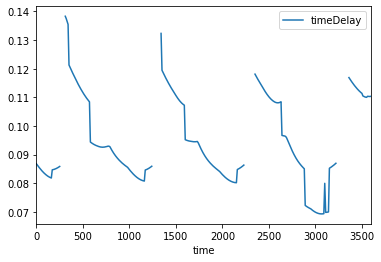

In [10]:
# Plot metric over time
df.plot.line(x='time',y=metric);

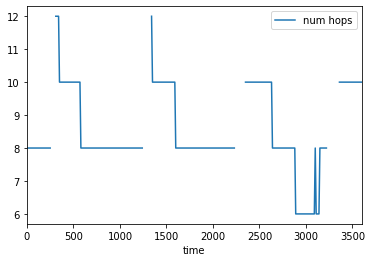

In [11]:
# Plot metric over time
df.plot.line(x='time',y='num hops');

In [12]:
# Create intervals for the strands and add to STK
dfIntervals = createDfIntervals(df,stop,step)
addStrandsAsObjectLines(stkRoot,dfIntervals,color='yellow')

In [13]:
# Add data back into STK
t1 = time.time()
addDataToSTK(stkRoot,chainNames[0],df)
print(time.time()-t1)

0.8596909046173096


## Example Scenario and Statistics

In [14]:
# Most active nodes
strands = dfIntervals[['strand','start','stop']].values
dfNodesIntervals = getNodesIntervalsFromStrands(strands)
dfNodeActive = getActiveDuration(dfNodesIntervals,start,stop)
dfNodeActive.sort_values('sum dur',ascending=False).head(10)

,sum dur,% time active
node,,
Target/Target3/Transmitter/Transmitter2,2045.0,56.805556
Facility/Facility1/Receiver/Receiver1,1485.0,41.250000
Facility/Facility5/Receiver/Receiver7,1465.0,40.694444
Satellite/LEO11/Receiver/Receiver3,1300.0,36.111111
Satellite/LEO11/Transmitter/Transmitter3,1300.0,36.111111
Satellite/LEO12/Receiver/Receiver4,1280.0,35.555556
Satellite/LEO12/Transmitter/Transmitter4,1280.0,35.555556
Target/Target1/Transmitter/Transmitter1,1175.0,32.638889
Satellite/LEO13/Receiver/Receiver5,1095.0,30.416667


In [15]:
# Summary stats for dur for each interval gap
dfIntervals[dfIntervals['strand'] == ''].describe()['dur']

count      4.000000
mean      95.000000
std       34.156503
min       50.000000
25%       80.000000
50%      100.000000
75%      115.000000
max      130.000000
Name: dur, dtype: float64

In [16]:
# Look at a strand
t = 0
list(df.loc[df['time'] == t]['strand'])

[['Target/Target1/Transmitter/Transmitter1',
  'Satellite/LEO14/Receiver/Receiver6',
  'Satellite/LEO14/Transmitter/Transmitter6',
  'Satellite/LEO46/Receiver/Receiver28',
  'Satellite/LEO46/Transmitter/Transmitter28',
  'Satellite/LEO31/Receiver/Receiver17',
  'Satellite/LEO31/Transmitter/Transmitter17',
  'Satellite/LEO13/Receiver/Receiver5',
  'Satellite/LEO13/Transmitter/Transmitter5',
  'Facility/Facility1/Receiver/Receiver1']]

## Add constraint

In [17]:
# # Add a constraint and then recompute
# receiverPaths = FilterObjectsByType(stkRoot,'Receiver')
# for receiverPath in receiverPaths:
#     receiver = stkRoot.GetObjectFromPath(receiverPath)
#     try:
#         cnConstraint = receiver.AccessConstraints.AddNamedConstraint('C/N')
#     except:
#         cnConstraint = receiver.AccessConstraints.GetActiveNamedConstraint('C/N')
#     cnConstraint = cnConstraint.QueryInterface(STKObjects.IAgAccessCnstrMinMax)
#     cnConstraint.EnableMin = True
#     cnConstraint.Min = 1